In [69]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(include_top=False,input_shape=(224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [71]:
import glob
import pandas as pd 
#先不讀取圖片，要訓練再讀
df=pd.DataFrame(columns=["path","target"])
for p in glob.glob("/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新迪爵125/*.jpg"):
#for p in glob.glob("/content/gdrive/MyDrive/sym新迪爵125/*.jpg"):
  s =pd.Series([p,0],index=["path","target"])
  df= df.append(s,ignore_index=True)
for p in glob.glob("/content/gdrive/MyDrive/Tebame_第四組_機車辨識/薛宇睿/GOGORO S2/*.jpg"):
  s =pd.Series([p,1],index=["path","target"])
  df= df.append(s,ignore_index=True)
df

,path,target
0,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新...,0
1,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新...,0
2,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新...,0
3,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新...,0
4,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新...,0
...,...,...
321,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/薛宇睿/GO...,1
322,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/薛宇睿/GO...,1
323,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/薛宇睿/GO...,1
324,/content/gdrive/MyDrive/Tebame_第四組_機車辨識/薛宇睿/GO...,1


/content/gdrive/MyDrive/Tebame_第四組_機車辨識/倫/sym新迪爵125/103.jpg
(691, 518)


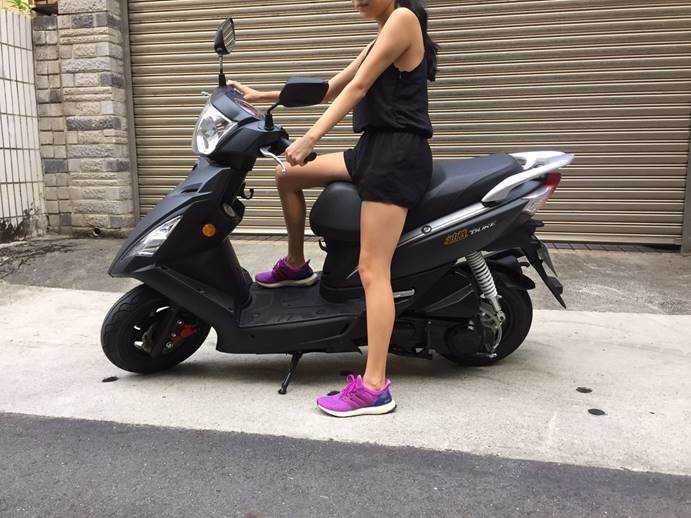

In [72]:
from keras.preprocessing.image import load_img
import random
c=random.randint(0,149)
print(df["path"][c])
img=load_img(df["path"][c])
print(img.size)
img

(224, 224)


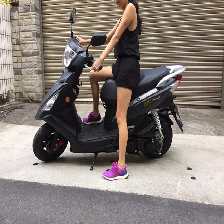

In [73]:
img=load_img(df["path"][c],target_size=(224,224))
print(img.size)
img

In [92]:
from keras.models import Model
from keras.layers import Flatten,Dense, BatchNormalization
#CNN(眼睛)
for l in vgg.layers:
  l.trainable=False
#BN(血管)
x=BatchNormalization()(vgg.output)
#MLP(大腦)
x=Flatten()(x)
x=Dense(units=2048,activation="relu")(x)
x=Dense(units=256,activation="relu")(x)
#貓和狗分類:units=1,units=2 都可以
#     :sigmoid,softmax
x=Dense(units=2,activation="softmax")(x)
cnn=Model(inputs=vgg.input,outputs=x)
cnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [93]:
vgg.layers

In [94]:
cnn.compile(loss="categorical_crossentropy",
      optimizer="adam",
      metrics=["accuracy"])

In [95]:
from sklearn.model_selection import train_test_split
#真的要開始切分和訓練的時候，請把你的pandas轉乘numpy的array
#先處理一下答案,把她轉換成one-hot
from keras.utils.np_utils import to_categorical
y_cat= to_categorical(df["target"])

import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                            np.array(y_cat),
                            test_size=0.1) 
#show一個y_train
y_train[0]                      

array([0., 1.], dtype=float32)

In [108]:
#你偷誰的模型，就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size=20
for i in range(5):
  #randint(下限(包括)，上限(不包括),幾個)
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  #numpy好用之處:array索引[list]
  imglist = []
  for fn in x_train[idx]:
    #讀取圖片並且使用我們偷來的模型預處理方式來處理一下
    img= load_img(fn,target_size=(224,224))
    img= preprocess_input(np.array(img))
    imglist.append(img)
  x= np.array(imglist)
  y= y_train[idx]
  result=cnn.train_on_batch(x,y)
  print("-----Times",i,"-----")
  print(result)

-----Times 0 -----
[10.521190643310547, 0.75]
-----Times 1 -----
[0.00019081158097833395, 1.0]
-----Times 2 -----
[0.7705560922622681, 0.8999999761581421]
-----Times 3 -----
[0.000306942209135741, 1.0]
-----Times 4 -----
[0.14451171457767487, 0.949999988079071]


In [109]:
batch_size=100
#randint(下限(包括)，上限(不包括),幾個)
idx=np.random.randint(0,x_test.shape[0],batch_size)
#numpy好用之處:array索引[list]
imglist = []
oriimglist = []
for fn in x_test[idx]:
  #讀取圖片並且使用我們偷來的模型預處理方式來處理一下
  img= load_img(fn,target_size=(224,224))
  #先把原圖留下來
  oriimglist.append(img)
  img= preprocess_input(np.array(img))
  imglist.append(img)
x= np.array(imglist)
y= y_test[idx]
cnn.evaluate(x,y)


4/4 [==============================] - 44s 10s/step - loss: 2.9305 - accuracy: 0.9500


[2.9304583072662354, 0.949999988079071]

In [104]:
#作圖(參考)
pre=cnn.predict(x).argmax(axis=-1)
pre 

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [106]:
y.argmax(axis=-1)

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

In [107]:
np.nonzero(pre !=y.argmax(axis=-1))

(array([ 1,  5, 10, 16, 20, 22, 24, 29, 30, 32, 34, 35, 43, 49, 50, 53, 55,
        61, 62, 63, 64, 65, 74, 76, 77, 79, 84, 91, 93, 96]),)